In [1]:
# Instala librerías necesarias
!pip install torch


[notice] A new release of pip is available: 24.1 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Importa las librerías necesarias
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

## Experimento para la búsqueda de la solución de la EDP de la divergencia de u por PINN [2,10,10,10,10,1] en grilla 20x20, con optimizador Adam y activación Tanh al igual que el caso original.

### 0 - Sin agregar mejoras: 

Epoch 0, Loss: 0.45358994603157043
Epoch 100, Loss: 0.06014029681682587
Epoch 200, Loss: 0.03388950973749161
Epoch 300, Loss: 0.009033597074449062
Epoch 400, Loss: 0.005239053629338741
Epoch 500, Loss: 0.0031711957417428493
Epoch 600, Loss: 0.001990849617868662
Epoch 700, Loss: 0.0014197725104168057
Epoch 800, Loss: 0.0011582419974729419
Epoch 900, Loss: 0.0010027242824435234
Epoch 1000, Loss: 0.0008857422508299351
Epoch 1100, Loss: 0.0007927740225568414
Epoch 1200, Loss: 0.0007201178232207894
Epoch 1300, Loss: 0.0006652186275459826
Epoch 1400, Loss: 0.0006241162773221731
Epoch 1500, Loss: 0.0005920114344917238
Epoch 1600, Loss: 0.00056487723486498
Epoch 1700, Loss: 0.000540217210073024
Epoch 1800, Loss: 0.0005169471260160208
Epoch 1900, Loss: 0.0004945513792335987
Epoch 2000, Loss: 0.0004732904490083456
Epoch 2100, Loss: 0.00045325045357458293
Epoch 2200, Loss: 0.00043470587115734816
Epoch 2300, Loss: 0.00041859576595015824
Epoch 2400, Loss: 0.00040261802496388555
Epoch 2500, Loss: 0.

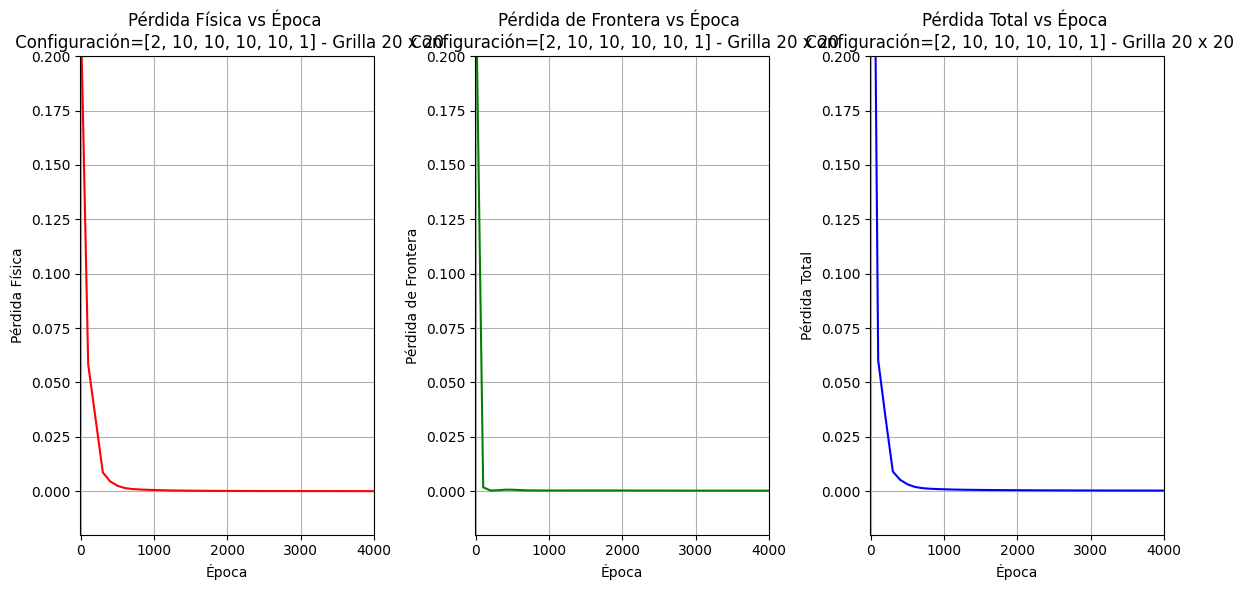

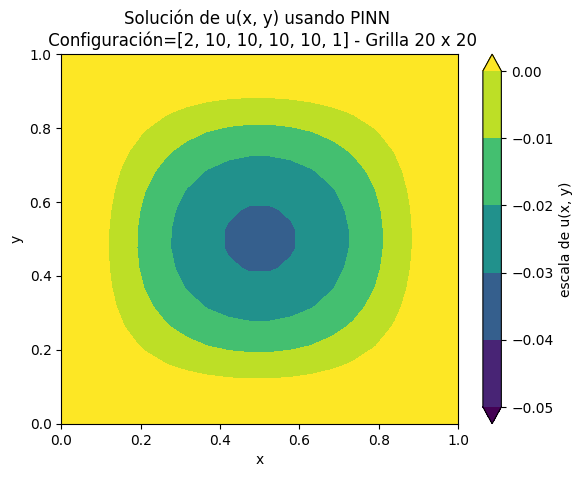

In [25]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)    # Entrada
        self.fc2 = nn.Linear(10, 10)   # Capa oculta 1
        self.fc3 = nn.Linear(10, 10)   # Capa oculta 2
        self.fc4 = nn.Linear(10, 10)   # Capa oculta 3
        self.fc5 = nn.Linear(10, 1)    # Salida

    def forward(self, x, y):
        # Red neuronal feedforward
        xy = torch.cat((x, y), dim=1)  # Concatena x y para pasar como entrada
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        out = torch.tanh(self.fc4(out))
        out = self.fc5(out)
        return out

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Condiciones de frontera
def boundary_loss(x, y, model):
    u = model(x, y)
    return torch.mean(u**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física
    loss_boundary_list = []  # Lista para almacenar la pérdida de frontera
    total_loss_list = []  # Lista para almacenar la pérdida total

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)
        loss_boundary = boundary_loss(x, y, model)

        # Pérdida total
        loss = loss_physics + loss_boundary

        # Optimización
        loss.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            loss_boundary_list.append(loss_boundary.item())
            total_loss_list.append(loss.item())
            print(f"Epoch {epoch}, Loss: {loss.item()}")

    return model, loss_physics_list, loss_boundary_list, total_loss_list

# Inicializa la red neuronal y el optimizador
model = PINN()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define la malla 20x20 fuera del entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_() 
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij') 
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Entrena el modelo
trained_model, loss_physics_list, loss_boundary_list, total_loss_list = train(model, optimizer, x, y)

# Crea los valores de las épocas a graficar
epochs = np.arange(0, 10000, 100)

# Gráfica las pérdidas
plt.figure(figsize=(12, 6))

# Gráfica de la pérdida física
plt.subplot(1, 3, 1)
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época \n Configuración=[2, 10, 10, 10, 10, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida de frontera
plt.subplot(1, 3, 2)
plt.plot(epochs, loss_boundary_list, label='Pérdida de Frontera', color='g')
plt.xlabel('Época')
plt.ylabel('Pérdida de Frontera')
plt.title('Pérdida de Frontera vs Época \n Configuración=[2, 10, 10, 10, 10, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

# Gráfica de la pérdida total
plt.subplot(1, 3, 3)
plt.plot(epochs, total_loss_list, label='Pérdida Total', color='b')
plt.xlabel('Época')
plt.ylabel('Pérdida Total')
plt.title('Pérdida Total vs Época \n Configuración=[2, 10, 10, 10, 10, 1] - Grilla 20 x 20')
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.grid(True)

plt.tight_layout()
plt.show()

# Evalua y visualizar los resultados
# Evalua el modelo en la malla definida
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)

# Convierte x e y a numpy para que coincidan con la forma de u_pred
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

# Visualización de los resultados
cp = plt.contourf(x_20x20, y_20x20, u_pred_20x20, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Configuración=[2, 10, 10, 10, 10, 1] - Grilla 20 x 20")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

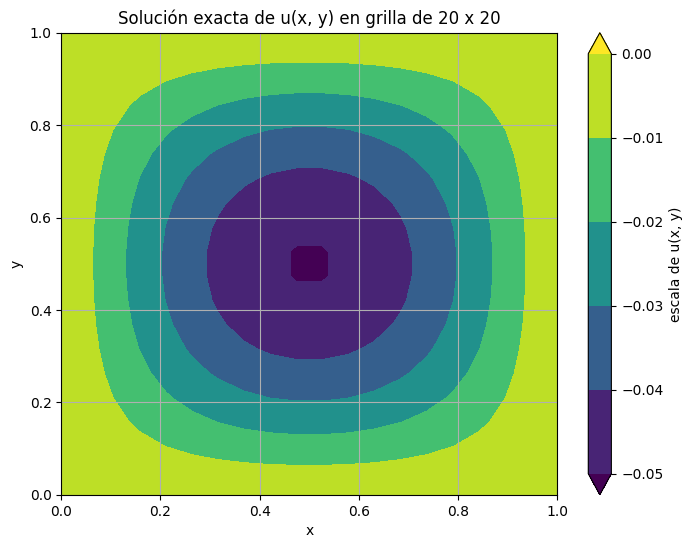

In [26]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_20x20, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

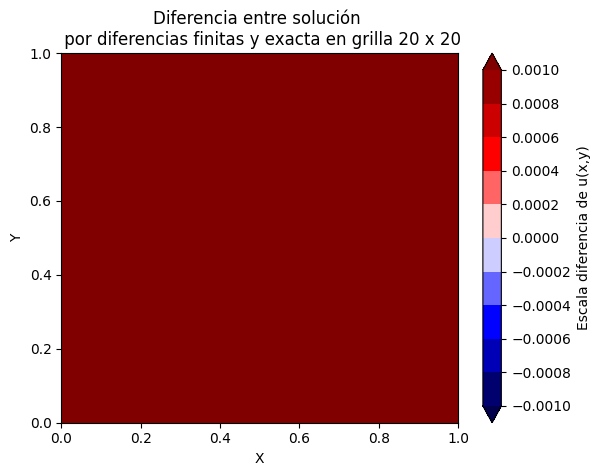

In [27]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_20x20, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20

### I - Agregando implementación “hard” de CB Dirichlet:

Epoch 0, Loss: 0.17900200188159943
Epoch 100, Loss: 0.030525922775268555
Epoch 200, Loss: 0.02957102842628956
Epoch 300, Loss: 0.027122920379042625
Epoch 400, Loss: 0.016733506694436073
Epoch 500, Loss: 0.00256475736387074
Epoch 600, Loss: 0.00033594632986932993
Epoch 700, Loss: 0.00014260764874052256
Epoch 800, Loss: 8.316981256939471e-05
Epoch 900, Loss: 6.025011680321768e-05
Epoch 1000, Loss: 4.904085653834045e-05
Epoch 1100, Loss: 4.248109689797275e-05
Epoch 1200, Loss: 3.801827915594913e-05
Epoch 1300, Loss: 3.458022547420114e-05
Epoch 1400, Loss: 3.169329647789709e-05
Epoch 1500, Loss: 2.914195465564262e-05
Epoch 1600, Loss: 2.6823086955118924e-05
Epoch 1700, Loss: 2.468365892127622e-05
Epoch 1800, Loss: 2.2695605366607197e-05
Epoch 1900, Loss: 2.0844587197643705e-05
Epoch 2000, Loss: 1.912512379931286e-05
Epoch 2100, Loss: 1.7536745872348547e-05
Epoch 2200, Loss: 1.608115780982189e-05
Epoch 2300, Loss: 1.4759996702196077e-05
Epoch 2400, Loss: 1.3573182513937354e-05
Epoch 2500, L

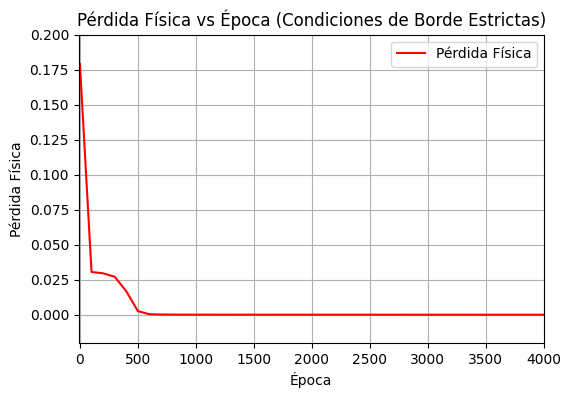

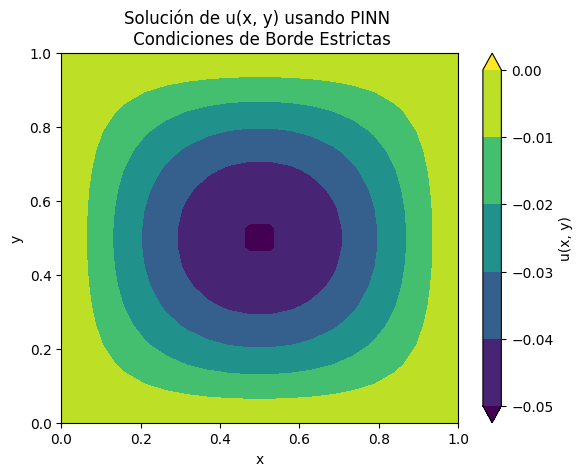

In [19]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 10)  # Capa oculta 2
        self.fc4 = nn.Linear(10, 10)  # Capa oculta 3
        self.fc5 = nn.Linear(10, 1)  # Salida

    def forward(self, x, y):
        # Concatena x y para pasar como entrada
        xy = torch.cat((x, y), dim=1)
        # Red neuronal feedforward con activaciones tanh
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        out = torch.tanh(self.fc4(out))
        out = self.fc5(out)
        return out

# Modifica la salida para cumplir con condiciones de borde
class PINNWithBoundary(PINN):
    def forward(self, x, y):
        # Define la salida de la red neuronal base
        u_hat = super().forward(x, y)
        # Implementa las condiciones de borde estrictamente
        u = (1 - x) * x * (1 - y) * y * u_hat  # Cumple con u(x=0, y)=u(x=1, y)=u(x, y=0)=u(x, y=1)=0
        return u

# Define la ecuación de la física
def physics_loss(x, y, model):
    u = model(x, y)

    # Derivadas parciales de u respecto a x e y
    u_x = torch.autograd.grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
    u_y = torch.autograd.grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]

    # Derivadas segundas de u respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Función de entrenamiento
def train(model, optimizer, x, y, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x, y, model)

        # Optimización
        loss_physics.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            print(f"Epoch {epoch}, Loss: {loss_physics.item()}")

    return model, loss_physics_list

# Definir los puntos de colocación (malla 20x20) fuera de la función de entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x = x.flatten().reshape(-1, 1)
y = y.flatten().reshape(-1, 1)

# Inicializa la red neuronal y el optimizador
model = PINNWithBoundary()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrena el modelo
trained_model, loss_physics_list = train(model, optimizer, x, y)

# Grafica la pérdida física
epochs = np.arange(0, 10000, 100)

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época (Condiciones de Borde Estrictas)')
plt.grid(True)
plt.legend()
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.show()

# Evaluación y visualización
u_pred_20x20 = trained_model(x, y).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)
x_20x20 = x.reshape(20, 20).detach().numpy()
y_20x20 = y.reshape(20, 20).detach().numpy()

cp = plt.contourf(x_20x20, y_20x20, u_pred_20x20, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Condiciones de Borde Estrictas")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

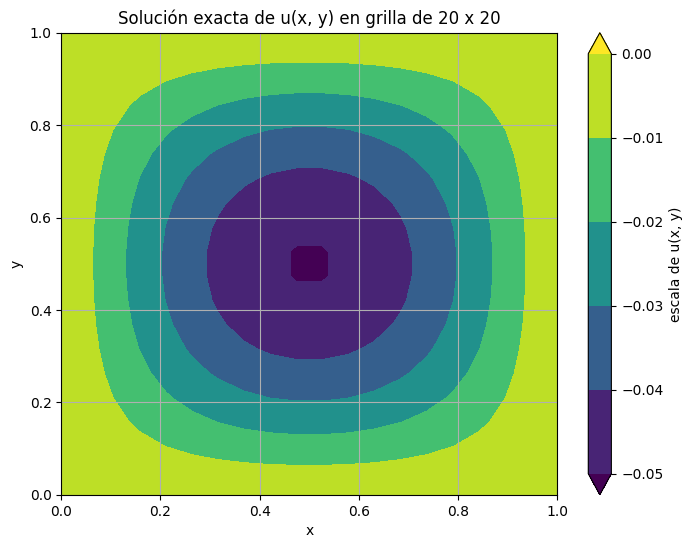

In [20]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_20x20, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

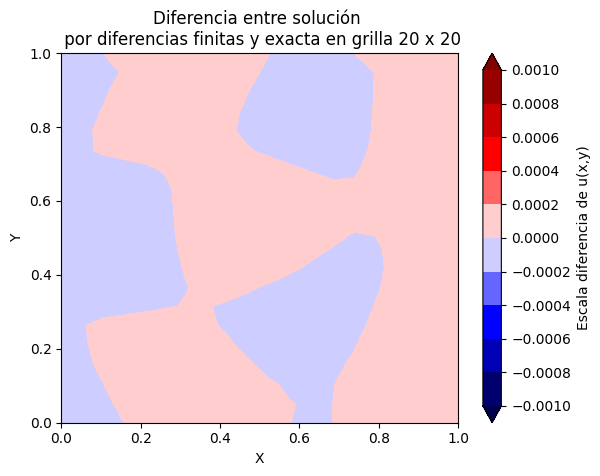

In [21]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_20x20, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20

### V - Igual al anterior, pero agregando Adimensionalización por dominio espacial.

Epoch 0, Loss: 18.19268035888672
Epoch 100, Loss: 0.0749308168888092
Epoch 200, Loss: 0.038561031222343445
Epoch 300, Loss: 0.01895877532660961
Epoch 400, Loss: 0.009328406304121017
Epoch 500, Loss: 0.004759063478559256
Epoch 600, Loss: 0.0026268211659044027
Epoch 700, Loss: 0.0016248829197138548
Epoch 800, Loss: 0.0011344064259901643
Epoch 900, Loss: 0.0008793363813310862
Epoch 1000, Loss: 0.0007405492942780256
Epoch 1100, Loss: 0.0006639654748141766
Epoch 1200, Loss: 0.0006216363399289548
Epoch 1300, Loss: 0.000597561476752162
Epoch 1400, Loss: 0.0005825338303111494
Epoch 1500, Loss: 0.000571547425352037
Epoch 1600, Loss: 0.0005621315794996917
Epoch 1700, Loss: 0.0005531715578399599
Epoch 1800, Loss: 0.0005442032706923783
Epoch 1900, Loss: 0.0005350676365196705
Epoch 2000, Loss: 0.0005257170414552093
Epoch 2100, Loss: 0.0005161386216059327
Epoch 2200, Loss: 0.000506328244227916
Epoch 2300, Loss: 0.0004963131505064666
Epoch 2400, Loss: 0.0004861027409788221
Epoch 2500, Loss: 0.0004757

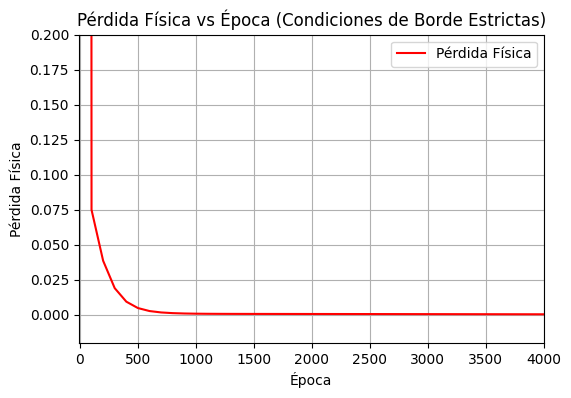

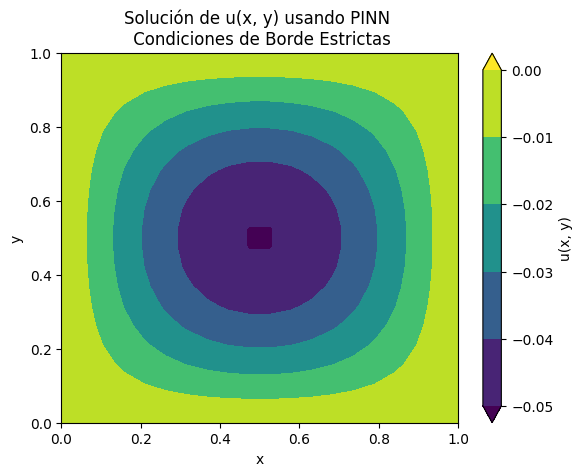

In [22]:
# Define la red neuronal
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        self.fc1 = nn.Linear(2, 10)  # Entrada
        self.fc2 = nn.Linear(10, 10)  # Capa oculta 1
        self.fc3 = nn.Linear(10, 10)  # Capa oculta 2
        self.fc4 = nn.Linear(10, 10)  # Capa oculta 3
        self.fc5 = nn.Linear(10, 1)  # Salida

    def forward(self, x, y):
        # Concatena x y para pasar como entrada
        xy = torch.cat((x, y), dim=1)
        # Red neuronal feedforward con activaciones tanh
        out = torch.tanh(self.fc1(xy))
        out = torch.tanh(self.fc2(out))
        out = torch.tanh(self.fc3(out))
        out = torch.tanh(self.fc4(out))
        out = self.fc5(out)
        return out

# Modifica la salida para cumplir con condiciones de borde
class PINNWithBoundary(PINN):
    def __init__(self):
        super(PINNWithBoundary, self).__init__()

        # U_ref es una constante de referencia para la adimensionalización de u
        self.U_ref = 0.01  # valor arbitrario (órden de magnitud de la solución) como constante de referencia

    def forward(self, x, y):
        # Obtiene la salida de la red neuronal (u_hat)
        u_hat = super().forward(x, y)

        # Adimensionaliza la salida de la red neuronal
        u_star = u_hat / self.U_ref

        # Implementa las condiciones de frontera estrictas sobre la salida adimensionalizada
        u_star = (1 - x) * x * (1 - y) * y * u_star  # Cumple con u(x=0, y)=u(x=1, y)=u(x, y=0)=u(x, y=1)=0
        
        return u_star

# Define la ecuación de la física (adimensionalizada)
def physics_loss(x, y, model):
    u_star = model(x, y)

    # Derivadas parciales de u* respecto a x e y
    u_x = torch.autograd.grad(u_star, x, grad_outputs=torch.ones_like(u_star), create_graph=True)[0]
    u_y = torch.autograd.grad(u_star, y, grad_outputs=torch.ones_like(u_star), create_graph=True)[0]

    # Derivadas segundas de u* respecto a x e y
    u_xx = torch.autograd.grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]

    # Laplaciano de u*
    laplacian_u = u_xx + u_yy

    # Residuo de la ecuación diferencial en forma adimensionalizada
    res = laplacian_u - torch.sin(np.pi * x) * torch.sin(np.pi * y)
    return torch.mean(res**2)

# Función de entrenamiento
def train(model, optimizer, x_train, y_train, n_epochs=10000):
    loss_physics_list = []  # Lista para almacenar la pérdida física

    for epoch in range(n_epochs):
        optimizer.zero_grad()

        # Cálculo de las pérdidas
        loss_physics = physics_loss(x_train, y_train, model)

        # Optimización
        loss_physics.backward()
        optimizer.step()

        # Almacena los valores de la pérdida cada 100 épocas
        if epoch % 100 == 0:
            loss_physics_list.append(loss_physics.item())
            print(f"Epoch {epoch}, Loss: {loss_physics.item()}")

    return model, loss_physics_list

# Definir puntos de colocación fuera del ciclo de entrenamiento
x = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
y = torch.linspace(0.0, 1.0, 20).reshape(-1, 1).requires_grad_()
x, y = torch.meshgrid(x.squeeze(), y.squeeze(), indexing='ij')
x_train = x.flatten().reshape(-1, 1)
y_train = y.flatten().reshape(-1, 1)

# Inicializa la red neuronal y el optimizador
model = PINNWithBoundary()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Entrena el modelo
trained_model, loss_physics_list = train(model, optimizer, x_train, y_train)

# Grafica la pérdida física
epochs = np.arange(0, 10000, 100)

plt.figure(figsize=(6, 4))
plt.plot(epochs, loss_physics_list, label='Pérdida Física', color='r')
plt.xlabel('Época')
plt.ylabel('Pérdida Física')
plt.title('Pérdida Física vs Época (Condiciones de Borde Estrictas)')
plt.grid(True)
plt.legend()
plt.xlim([-10, 4000])
plt.ylim([-0.02, 0.20])
plt.show()

# Evaluación y visualización
u_pred_20x20 = trained_model(x_train, y_train).detach().numpy()
u_pred_20x20 = u_pred_20x20.reshape(20, 20)
x_20x20 = x_train.reshape(20, 20).detach().numpy()
y_20x20 = y_train.reshape(20, 20).detach().numpy()

cp = plt.contourf(x_20x20, y_20x20, u_pred_20x20, cmap='viridis', levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(cp, label='u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title("Solución de u(x, y) usando PINN \n Condiciones de Borde Estrictas")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Solución Exacta

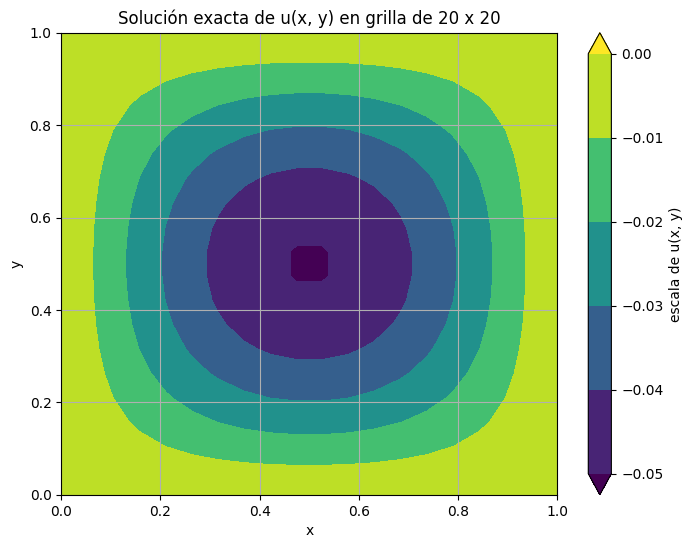

In [23]:
# Define la función u(x, y)
def u(x, y):
    return -1 / (2 * np.pi**2) * np.sin(np.pi * x) * np.sin(np.pi * y)

# Crea la malla de 10x10 en el dominio 0 < x < 1; 0 < y < 1
x = np.linspace(0, 1, 20)
y = np.linspace(0, 1, 20)
X, Y = np.meshgrid(x, y)

# Calcula los valores de u en la malla
u_SE_20x20 = u(X, Y)

# Grafica el campo
plt.figure(figsize=(8, 6))
plt.contourf(X, Y, u_SE_20x20, levels=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00], vmin=-0.05, vmax=0.00, extend='both')
plt.colorbar(label='escala de u(x, y)', extend='both', ticks=[-0.05, -0.04, -0.03, -0.02, -0.01, 0.00])
plt.title(f'Solución exacta de u(x, y) en grilla de 20 x 20')
plt.xlabel('x')
plt.ylabel('y')
plt.grid()
plt.show()

Diferencia

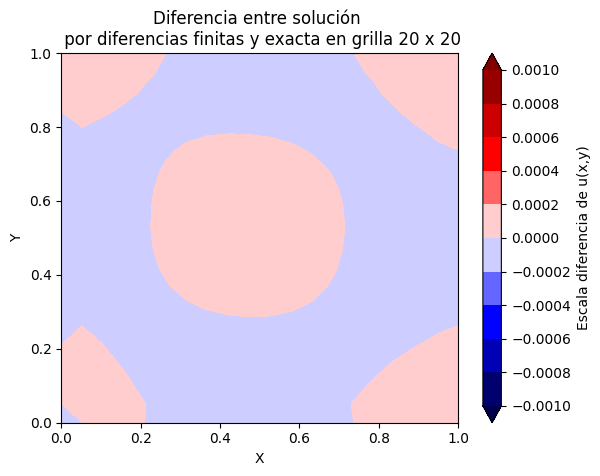

In [24]:
# Calcula la diferencia entre los dos campos
diferencia_20x20 = u_pred_20x20 - u_SE_20x20

# Define una grilla para las coordenadas X e Y
x = np.linspace(0, 1, diferencia_20x20.shape[1])
y = np.linspace(0, 1, diferencia_20x20.shape[0])
X, Y = np.meshgrid(x, y)

# Plotea la diferencia usando contourf
plt.contourf(X, Y, diferencia_20x20, cmap='seismic', levels=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010], vmin=-0.0010, vmax=0.0010, extend='both')
plt.colorbar(label='Escala diferencia de u(x,y)', extend='both', ticks=[-0.0010, -0.0008, -0.0006, -0.0004, -0.0002, 0.000, 0.0002, 0.0004, 0.0006, 0.0008, 0.0010])
plt.title('Diferencia entre solución \n por diferencias finitas y exacta en grilla 20 x 20')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

# Limpia la variable
del diferencia_20x20